2025-11-18 22:58:19.586252: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-18 22:58:19.586485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 22:58:19.621859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 22:58:20.461308: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Auto-selected test image: img_0019.jpg
Loading Model...
Model loaded successfully!

--- STARTING ANALYSIS ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


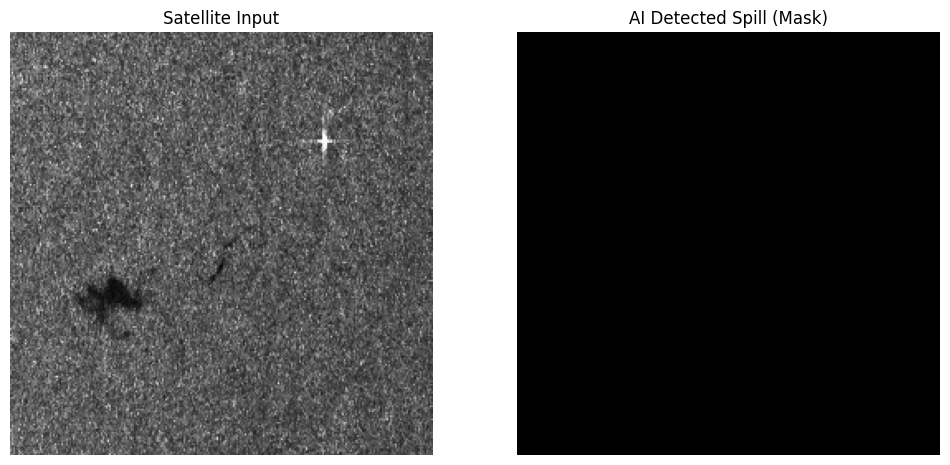


--- AIS VESSEL FORENSIC REPORT ---
Searching for ships near Lat: 28.5, Lon: -90.5...
Clear: MILLIE (ID: 368179260) - Speed: 7.3 knots (Moving)
SUSPECT: LOOP LIFTER (ID: 367659880) - Speed: 0.2 knots (STOPPED)
Clear: MISS MARILENE TIDE (ID: 369000000) - Speed: 1.0 knots (Moving)
SUSPECT: SOLITAIRE (ID: 249118000) - Speed: 0.1 knots (STOPPED)
SUSPECT: OCEAN BLACKHAWK (ID: 538005061) - Speed: 0.0 knots (STOPPED)
Clear: WHITETAIL (ID: 367619370) - Speed: 8.8 knots (Moving)
SUSPECT: L/B PAUL (ID: 368681000) - Speed: 0.0 knots (STOPPED)
SUSPECT: NOBLE FAYE KOZACK (ID: 636015856) - Speed: 0.1 knots (STOPPED)
SUSPECT: HOS RUGER (ID: 368264720) - Speed: 0.2 knots (STOPPED)
SUSPECT: LOOP LIFTER (ID: 367659880) - Speed: 0.6 knots (STOPPED)
SUSPECT: HOUSTON (ID: 367663150) - Speed: 0.0 knots (STOPPED)
SUSPECT: SOLITAIRE (ID: 249118000) - Speed: 0.1 knots (STOPPED)
Clear: HILDA LAB (ID: 338536000) - Speed: 8.4 knots (Moving)
Clear: MISS MARILENE TIDE (ID: 369000000) - Speed: 1.2 knots (Moving)
SUS

In [1]:
# 3_Final_Inference.ipynb

import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import load_model

# --- 1. CONFIGURATION ---
MODEL_PATH = '../saved_models/unet_oil_spill.h5' 
AIS_DATA_PATH = '../data/ais_data/vessel_data_clean.csv' # Points to your CLEAN file

# AUTOMATICALLY FIND A TEST IMAGE
# This looks into your test folder and picks the first image it finds
TEST_DIR = '../data/test/images' 
TEST_IMG_PATH = None

if os.path.exists(TEST_DIR):
    files = os.listdir(TEST_DIR)
    if len(files) > 0:
        TEST_IMG_PATH = os.path.join(TEST_DIR, files[0]) # Pick the first file
        print(f"Auto-selected test image: {files[0]}")
    else:
        print("WARNING: No images found in '../data/test/images'. Please add one!")
else:
    # Fallback if folders aren't set up yet
    TEST_IMG_PATH = 'dummy_path.jpg' 

# --- 2. LOAD MODEL ---
print("Loading Model...")
try:
    model = load_model(MODEL_PATH)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Did you run '1_UNet_Training.ipynb' to generate the .h5 file?")

# --- 3. PREDICT FUNCTION (VISION) ---
def predict_spill(image_path):
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return np.zeros((256,256,3)), np.zeros((256,256,1))

    # Preprocess
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(original_img, (256, 256))
    img_input = np.expand_dims(img, axis=0) / 255.0 # Normalize
    
    # Predict
    mask_pred = model.predict(img_input)[0]
    mask_pred = (mask_pred > 0.5).astype(np.uint8) # Thresholding
    
    return img, mask_pred

# --- 4. ANOMALY DETECTION (DATA LOGIC) ---
def detect_anomaly(ais_csv, spill_lat, spill_lon, search_radius=0.5):
    """
    Reads the CLEAN CSV and finds ships near the spill_lat/lon.
    """
    if not os.path.exists(ais_csv):
        return ["Error: AIS CSV file not found. Run '0_Prepare_AIS.py' first."]

    df = pd.read_csv(ais_csv)
    
    # Filter ships strictly near the spill location
    # We create a small "box" around the spill coordinates
    nearby_ships = df[
        (df['LAT'] > spill_lat - search_radius) & 
        (df['LAT'] < spill_lat + search_radius) & 
        (df['LON'] > spill_lon - search_radius) & 
        (df['LON'] < spill_lon + search_radius)
    ]
    
    suspects = []
    
    if nearby_ships.empty:
        suspects.append("No ships found in this area during this time.")
    else:
        for index, ship in nearby_ships.iterrows():
            # RULE: If speed is very low (stopped) it's suspicious
            speed = ship['SOG']
            mmsi = ship['MMSI']
            name = str(ship['VesselName'])
            
            if speed < 1.0: 
                suspects.append(f"SUSPECT: {name} (ID: {mmsi}) - Speed: {speed} knots (STOPPED)")
            else:
                suspects.append(f"Clear: {name} (ID: {mmsi}) - Speed: {speed} knots (Moving)")
            
    return suspects

# --- 5. RUN PIPELINE ---

print("\n--- STARTING ANALYSIS ---")

# A. Run Visual Detection
# Note: If you don't have an image yet, this will show a black square.
final_img, final_mask = predict_spill(TEST_IMG_PATH)

# B. Run Data Detection
# We simulate a spill at these coordinates (Gulf of Mexico example)
# This matches the area we filtered for in Step 0
simulated_lat = 28.5
simulated_lon = -90.5

anomalies = detect_anomaly(AIS_DATA_PATH, simulated_lat, simulated_lon)

# C. Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Satellite Input")
plt.imshow(final_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("AI Detected Spill (Mask)")
plt.imshow(final_mask, cmap='gray')
plt.axis('off')

plt.show()

print("\n--- AIS VESSEL FORENSIC REPORT ---")
print(f"Searching for ships near Lat: {simulated_lat}, Lon: {simulated_lon}...")
for note in anomalies:
    print(note)